In [4]:
# This notebook contain data collection + understanding the effects of COVID-19 on human mobility and the situation of COVID in Ireland 
# For the Article Tittled Dublin Traffic Congestion During the COVID-19 Pandemic

In [5]:
import pandas as pd
import numpy as np
import pickle
import csv
import json
import os
# Visualization library
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
plotly.io.renderers.default = 'colab'
import plotly.graph_objs as go
import datetime 
import requests
import urllib.request
from bs4 import BeautifulSoup
from pprint import pprint
import datetime
from datetime import datetime, timedelta
import seaborn as sns
import plotly.express as px
from datetime import date
import holidays
from plotly.figure_factory import create_distplot

# Start & Finish Dates

In [6]:
# Defining start and end of the analysis
startdate = pd.to_datetime("2020-03-07").date()
enddate = pd.to_datetime("2022-02-01").date() 

# 1: Data Collection & Preperation Phase:

## A ) Covid Data 

### 1-  Ireland Counties Data
### GeoHive Open Data Catalogue - Covid19CountyStatisticsHPSCIrelandOpenData

In [7]:
# Loading Data from opendata-geohive.hub
covid = pd.read_csv("https://opendata.arcgis.com/datasets/d9be85b30d7748b5b7c09450b8aede63_0.csv",
                 usecols=['CountyName', 'PopulationCensus16', 'TimeStamp','ConfirmedCovidCases', 'Lat', 'Long'])
# Changing date type
covid['TimeStamp'] = pd.to_datetime(covid['TimeStamp']).dt.date

# Renaming columns
covid = covid.rename(columns={"CountyName": "region", "PopulationCensus16": "Population", "TimeStamp": "date", "ConfirmedCovidCases": 'Confirmed'})

# Filter start & end Date
#covid = covid.loc[(covid['date'] >= startdate) & (covid['date'] < enddate )]


In [8]:
covid.tail()

,region,Population,date,Lat,Long,Confirmed
18819,Tipperary,159553,2022-02-21,52.6407,-7.9206,38311
18820,Waterford,116176,2022-02-21,52.2035,-7.4935,30778
18821,Westmeath,88770,2022-02-21,53.5524,-7.4219,28260
18822,Wexford,149722,2022-02-21,52.5164,-6.5037,33835
18823,Wicklow,142425,2022-02-21,53.0205,-6.3442,31193


In [9]:
covid.date.min(),covid.date.max()

(datetime.date(2020, 2, 27), datetime.date(2022, 2, 21))

### 2- World Data:
### John Hopkings Dataset

In [10]:
# Specifing URL from John Hopkings DataSets
john_hopkings_dataset_confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
john_hopkings_dataset_recovered_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
john_hopkings_dataset_deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

# Data 
df_confirmed =  pd.read_csv (john_hopkings_dataset_confirmed_url)
df_recovered = pd.read_csv (john_hopkings_dataset_recovered_url)
df_deaths = pd.read_csv (john_hopkings_dataset_deaths_url )

In [11]:
#Changing  to long format
def transfer_covid_data (hopkin_url, covid_case):
    df =  pd.read_csv (hopkin_url)
    # Grouping data by country to have once single name for all countries
    df = df.groupby('Country/Region', as_index=False).sum()
    df = df.melt(id_vars = ['Country/Region', 'Lat', 'Long'],
             value_name=covid_case)
    # Simplify column names
    df.columns =  ['Country', 'Latitude', 'Longitude', 'Date', covid_case]
    return df
# Calling functions for our 3 seprated datasets:
df_confirmed = transfer_covid_data(john_hopkings_dataset_confirmed_url, 'Confirmed')
df_recovered = transfer_covid_data(john_hopkings_dataset_recovered_url, 'Recovered')
df_deaths = transfer_covid_data(john_hopkings_dataset_deaths_url, 'Deaths')

In [12]:
# Changing  to Country Features
def group_covid_data (hopkin_url, covid_case):
    '''
    Grouping data based on the "Country/Region and sum all the numbers related to that country
    Droping spatial features, since we are going to use some shape files for this purpose
    Transposing row and coulmns to se countries in rows and numbers based on the dates
    
    '''
    df =  pd.read_csv (hopkin_url)
    # Grouping data by country to have once single name for all countries
    df = df.groupby('Country/Region').sum()
    df_drop = df.drop (['Lat', 'Long'], axis = 1)
    df_drop = df_drop.T 
    return df_drop
# Calling functions for our 3 seprated datasets:
hopkings_confirmed = group_covid_data(john_hopkings_dataset_confirmed_url, 'Confirmed')
hopkings_recovered = group_covid_data(john_hopkings_dataset_recovered_url, 'Recovered')
hopkings_deaths = group_covid_data(john_hopkings_dataset_deaths_url, 'Deaths')

## B) Vaccine Data Ireland

In [13]:
vacccine_url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/country_data/Ireland.csv'
# Data 
vaccine =  pd.read_csv (vacccine_url)
vaccine = vaccine.drop(columns = ['location', 'vaccine', 'source_url', 'total_vaccinations', 'people_fully_vaccinated'])
# Changing date type
vaccine['date'] = pd.to_datetime(vaccine['date']).dt.date
# Filter start & end Date
vaccine = vaccine.loc[(vaccine['date'] >= startdate) & (vaccine ['date'] < enddate )]

In [14]:
vaccine.tail()

,date,people_vaccinated,total_boosters
393,2022-01-27,4021949,2699977
394,2022-01-28,4022972,2706690
395,2022-01-29,4025295,2710580
396,2022-01-30,4026929,2712563
397,2022-01-31,4027405,2715420


## C ) Apple Mobility Data

In [15]:
# get link via API
json_link = "https://covid19-static.cdn-apple.com/covid19-mobility-data/current/v3/index.json"
with urllib.request.urlopen(json_link) as url:
    json_data = json.loads(url.read().decode())
    link_apple = "https://covid19-static.cdn-apple.com" + \
json_data['basePath'] + json_data['regions']['en-us']['csvPath']

In [16]:
link_apple

'https://covid19-static.cdn-apple.com/covid19-mobility-data/2208HotfixDev15/v3/en-us/applemobilitytrends-2022-02-22.csv'

In [17]:
# Reading the apple csv file
apple = pd.read_csv(link_apple , low_memory=False)
countries = ['Ireland']
apple = apple[apple['country'].isin(countries)]
apple = apple.drop(columns=['geo_type','alternative_name', 'sub-region'])

apple = apple.melt(id_vars=[
            'country',
            'region',
            'transportation_type'],
        var_name='date')
# minus -100 to be similar to Google
apple['value'] = apple['value'] - 100

# Changing date type
apple['date'] = pd.to_datetime(apple['date']).dt.date

# Filter start & end Date
apple = apple.loc[(apple ['date'] >= startdate) & (apple ['date'] < enddate )]

In [19]:
apple = apple.pivot_table(
    index=[
            'country',
            'region',
            'date'],
    columns='transportation_type', values = 'value').reset_index()

In [20]:
apple.tail()

transportation_type,country,region,date,driving,transit,walking
13859,Ireland,Wicklow,2022-01-27,5.96,NaN,NaN
13860,Ireland,Wicklow,2022-01-28,29.89,NaN,NaN
13861,Ireland,Wicklow,2022-01-29,62.53,NaN,NaN
13862,Ireland,Wicklow,2022-01-30,44.22,NaN,NaN
13863,Ireland,Wicklow,2022-01-31,13.47,NaN,NaN


In [21]:
apple.date.min(), apple.date.max()

(datetime.date(2020, 3, 7), datetime.date(2022, 1, 31))

## D) Google Mobility Data

In [22]:
# get webpage source
url = 'https://www.google.com/covid19/mobility/'
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")
link_google = soup.find('a', {"class": "icon-link"})['href']

# Reading the apple csv file
google = pd.read_csv(link_google , low_memory=False)

In [23]:
# Filtering Ireland
country_code = ['IE']
google = google[google['country_region_code'].isin(country_code)]
# Changing date type
google['date'] = pd.to_datetime(google['date']).dt.date
# Filter start & end Date
google = google.loc[(google['date'] >= startdate) & (google ['date'] < enddate )]
# shorten value column names
google.columns = google.columns.str.replace('_percent_change_from_baseline', '')
# Remove underscore from column names
google.columns = google.columns.str.replace('_', ' ')
# Removing County char from region column
google['sub region 1'] =google['sub region 1'].str.replace('County ', '')
# Remove extra Columns
google = google.drop(columns = ['country region code',
                               #'country region',
                                'sub region 2',
                                'metro area',
                                'iso 3166 2 code',
                                'census fips code',
                                'place id'])
# Renaming columns
google = google.rename(columns = {'sub region 1': 'County', 
                         'date' : 'Date',
                         'retail and recreation': 'Retail and Recreation',
                         'grocery and pharmacy' : 'Grocery and Pharmacy',
                         'parks': 'Parks',
                         'transit stations': 'Transit Stations',
                         'workplaces': 'Workplaces',
                          'residential' : 'Residential'})

In [24]:
google.tail()

,country region,County,Date,Retail and Recreation,Grocery and Pharmacy,Parks,Transit Stations,Workplaces,Residential
3793225,Ireland,Wicklow,2022-01-27,3.0,14.0,34.0,-35.0,-26.0,10.0
3793226,Ireland,Wicklow,2022-01-28,-2.0,14.0,28.0,-34.0,-22.0,10.0
3793227,Ireland,Wicklow,2022-01-29,5.0,12.0,10.0,-21.0,-4.0,3.0
3793228,Ireland,Wicklow,2022-01-30,-5.0,2.0,3.0,-26.0,-6.0,3.0
3793229,Ireland,Wicklow,2022-01-31,-1.0,14.0,28.0,-32.0,-26.0,10.0


In [25]:
google.Date.min(), google.Date.max()

(datetime.date(2020, 3, 7), datetime.date(2022, 1, 31))

## E) Governments Restrictions Data (OxCGRT)

In [26]:
oxford_link= 'https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/OxCGRT_latest.csv'

In [27]:
oxford = pd.read_csv (oxford_link , low_memory=False)
#Changing Date format to be matched to other DFs
oxford['Date'] = pd.to_datetime(oxford['Date'], format='%Y%m%d')
# Changing date type
oxford['Date'] = pd.to_datetime(oxford['Date']).dt.date
# Filter start & end Date
oxford  = oxford .loc[(oxford ['Date'] >= startdate) & (oxford ['Date'] < enddate )]
# Filter Ireland
CountryName = ['Ireland']
oxford =oxford [oxford['CountryName'].isin(CountryName)]
# Dropping useless columns
oxford = oxford.drop (columns = ['CountryName',
                                 'CountryCode',
                                 'RegionName',
                                 'RegionCode',
                                 'Jurisdiction'])

In [29]:
oxford.Date.min(), oxford.Date.max()

(datetime.date(2020, 3, 7), datetime.date(2022, 1, 31))

In [30]:
oxford.shape

(696, 55)

## F) FaceBook Mobility Data

In [31]:
read_file = pd.read_csv (r'/content/movement-range-2022-02-01.txt',sep='\t',  low_memory=False)
#read_file.to_csv (r'C:/Users/Negee/Article 1 PhD/movement-range-2022-02-01', index=None)

In [32]:
facebook = read_file
countries_fb = ['IRL']
facebook= facebook[facebook['country'].isin(countries_fb)]

In [33]:
facebook.isna().sum()

ds                                            0.0
country                                       0.0
polygon_source                                0.0
polygon_id                                    0.0
polygon_name                                  0.0
all_day_bing_tiles_visited_relative_change    0.0
all_day_ratio_single_tile_users               0.0
baseline_name                                 0.0
baseline_type                                 0.0
dtype: float64

In [34]:
#Changing Date format to be matched to other DFs
facebook['ds'] = pd.to_datetime(facebook['ds'], format='%Y/%m/%d')
# Changing date type
facebook['ds'] = pd.to_datetime(facebook['ds']).dt.date
# Filter start & end Date
facebook  = facebook.loc[(facebook['ds'] >= startdate) & (facebook['ds'] < enddate )]
# Dropping useless columns
facebook = facebook.drop (columns = ['country',
                                 'polygon_source',
                                 'polygon_id',
                                 'baseline_name',
                                 'baseline_type'])
# Renaming columns
facebook = facebook.rename(columns = {'ds': 'Date', 
                         'polygon_name' : 'County'})

In [36]:
facebook .head()

,Date,County,all_day_bing_tiles_visited_relative_change,all_day_ratio_single_tile_users


# 2: Data Cleaning Phase :

## Covid-19

## Ireland

In [117]:
covid.tail(1)

,region,Population,date,Lat,Long,Confirmed,Daily_Confirmed,Incident_Rate
18823,Wicklow,142425,2022-02-21,53.0205,-6.3442,31193,127.0,8.916974e-09


In [39]:
# NA in data
covid.isna().sum()

region        0
Population    0
date          0
Lat           0
Long          0
Confirmed     0
dtype: int64

#### COVID-19 Incident + Confirmed Cases Feature creation for Counties in Ireland

In [40]:
# Daily Positve Cases:
# Daily- Confirmed_ cases
covid ['Daily_Confirmed'] = covid.sort_values('date').groupby(['region', 'Population'])['Confirmed'].diff()

#Incident Rate:
# How many cases would appear annually for every 100,000 people in a population
covid['Incident_Rate'] = (covid['Daily_Confirmed']/(covid['Population'] * 100000))

In [41]:
covid.head(10)

,region,Population,date,Lat,Long,Confirmed,Daily_Confirmed,Incident_Rate
0,Carlow,56932,2020-02-27,52.7168,-6.8367,0,NaN,NaN
1,Cavan,76176,2020-02-27,53.9878,-7.2937,0,NaN,NaN
2,Clare,118817,2020-02-27,52.8917,-8.9889,0,NaN,NaN
3,Cork,542868,2020-02-27,51.9517,-8.6372,0,NaN,NaN
4,Donegal,159192,2020-02-27,54.8989,-7.9600,0,NaN,NaN
5,Dublin,1347359,2020-02-27,53.3605,-6.2920,0,NaN,NaN
6,Galway,258058,2020-02-27,53.3705,-8.7362,0,NaN,NaN
7,Kerry,147707,2020-02-27,52.1689,-9.5650,0,NaN,NaN
8,Kildare,222504,2020-02-27,53.2380,-6.7837,0,NaN,NaN
9,Kilkenny,99232,2020-02-27,52.5816,-7.2175,0,NaN,NaN


## World COVID Data

#### New Features:
- Daily new confirmed cases
- Daily new death cases
- Growth confirmed cases
- Growth death cases
- Death Rate

In [42]:
# Copying dataset to make sure that we would keep the main DF
daily_confirmed = hopkings_confirmed.copy()
daily_deaths = hopkings_deaths.copy()
growth_confirmed = hopkings_confirmed.copy()
growth_deaths = hopkings_deaths.copy()

In [43]:
rows_len =len (hopkings_confirmed)

# Calculating the daily number of confirmed cases & death + their growth rate
for date in range (1,rows_len ):
    #print (daily_confirmed.iloc[day])
    # Comparin the date with a day before to see the number of new cases both deaths and confirmed
    daily_confirmed.iloc[date] = hopkings_confirmed.iloc[date] - hopkings_confirmed.iloc[date-1]
    daily_deaths.iloc[date] = hopkings_deaths.iloc[date] - hopkings_deaths.iloc[date-1]
    # Calculating growth rate = COVID-19 growth rate = (number of new cases in new_day) / 
    #Total number of newcases till day before) *100
    growth_confirmed.iloc[date] = (daily_confirmed.iloc[date] / hopkings_confirmed.iloc[date-1]) * 100
    growth_deaths.iloc[date] = (daily_deaths.iloc[date] / hopkings_deaths.iloc[date-1]) * 100
    #print (daily_confirmed.iloc[day-1])
    #print (daily_confirmed.iloc[day])
# Calculating growth rate for all countries (comparing death and confimed)
death_rate = hopkings_deaths.copy()
# Formula = dividing total number of death on each date based on total confirmed date
for date in range (0, rows_len):
    death_rate.iloc[date] = (hopkings_deaths.iloc[date] / hopkings_confirmed.iloc[date]) * 100

## Google

In [45]:
google.describe()

,Retail and Recreation,Grocery and Pharmacy,Parks,Transit Stations,Workplaces,Residential
count,17673.000000,17768.000000,10372.000000,13519.000000,18441.000000,15554.000000
mean,-22.585639,8.644192,14.254339,-31.835195,-29.074779,8.756719
std,29.153761,20.241040,49.134910,24.771661,18.920036,8.099369
min,-96.000000,-96.000000,-100.000000,-92.000000,-89.000000,-8.000000
25%,-45.000000,-3.000000,-18.000000,-50.000000,-41.000000,2.000000
50%,-20.000000,8.000000,7.000000,-33.000000,-28.000000,8.000000
75%,0.000000,21.000000,38.000000,-17.000000,-17.000000,14.000000
max,96.000000,107.000000,267.000000,111.000000,41.000000,38.000000


Mean Mobility Changes in Ireland

In [46]:
google.groupby('country region').mean()

,Retail and Recreation,Grocery and Pharmacy,Parks,Transit Stations,Workplaces,Residential
country region,,,,,,
Ireland,-22.585639,8.644192,14.254339,-31.835195,-29.074779,8.756719


## Handling Missing Values

In [48]:
print ('total number of NA values is Google ' , google.isna().sum().sum())

total number of NA values is Google  19011


Parks, Transit Stations, Residential Shows the top 3 missed values in Ireland

In [49]:
nan_columns = []
nan_mobility = []
for column in google.columns:
    nan_columns.append(column)
    nan_mobility.append(google[column].isnull().sum())
number_of_miss_values_features = dict(zip(nan_columns, nan_mobility))
print('The missing value for each feature is:\n', number_of_miss_values_features)

The missing value for each feature is:
 {'country region': 0, 'County': 696, 'Date': 0, 'Retail and Recreation': 934, 'Grocery and Pharmacy': 839, 'Parks': 8235, 'Transit Stations': 5088, 'Workplaces': 166, 'Residential': 3053}


In [50]:
google_IR = google.copy()

In [51]:
# DF of the Ireland status withouth County level
google_Ireland_status = google_IR[google_IR['County'].isna()].reset_index(drop=True)
# DF of the Ireland status with County level
google_county_status = google_IR[google_IR['County'].notna()].reset_index(drop=True)

# Creating the array that saves the value for each day
len_google_ireland = len(google_Ireland_status)
# Empty arrays to store values
daily_status_mob_val_r_r = np.array([])
daily_status_mob_val_g_p = np.array([])
daily_status_mob_val_p = np.array([])
daily_status_mob_val_t = np.array([])
daily_status_mob_val_w = np.array([])
daily_status_mob_val_r = np.array([])

for i in range (0, len_google_ireland):
    
    mob_val_r_r = google_Ireland_status.loc[i]['Retail and Recreation']
    mob_val_g_p = google_Ireland_status.loc[i]['Grocery and Pharmacy']
    mob_val_p = google_Ireland_status.loc[i]['Parks']
    mob_val_t = google_Ireland_status.loc[i]['Transit Stations']
    mob_val_w = google_Ireland_status.loc[i]['Workplaces']
    mob_val_r = google_Ireland_status.loc[i]['Residential']
    
    # For all 26 Irish counties
    for k in range (1, 27):
        
        daily_status_mob_val_r_r = np.append(daily_status_mob_val_r_r, mob_val_r_r)
        daily_status_mob_val_g_p = np.append( daily_status_mob_val_g_p  , mob_val_g_p)
        daily_status_mob_val_p = np.append( daily_status_mob_val_p , mob_val_p )
        daily_status_mob_val_t = np.append( daily_status_mob_val_t  , mob_val_t )
        daily_status_mob_val_w = np.append( daily_status_mob_val_w , mob_val_w)
        daily_status_mob_val_r = np.append( daily_status_mob_val_r , mob_val_r)


In [ ]:
# 1- Cleaning 'Retail and Recreation'
for i, j in google_county_status['Retail and Recreation'].iteritems():
    if pd.isnull(j):
        google_county_status['Retail and Recreation'] = google_county_status['Retail and Recreation'].fillna(daily_status_mob_val_r_r[i]).to_frame()
    else:
        pass

# 2- Cleaning 'Grocery and Pharmacy'   
for i, j in google_county_status['Grocery and Pharmacy'].iteritems():
    if pd.isnull(j):
        google_county_status['Grocery and Pharmacy'] = google_county_status['Grocery and Pharmacy'].fillna(daily_status_mob_val_g_p[i]).to_frame()
    else:
        pass


# 3- Cleaning 'Parks'   
for i, j in google_county_status['Parks'].iteritems():
    if pd.isnull(j):
        google_county_status['Parks'] = google_county_status['Parks'].fillna(daily_status_mob_val_p[i]).to_frame()
    else:
        pass

# 4- Cleaning 'Transit Stations'   
for i, j in google_county_status['Transit Stations'].iteritems():
    if pd.isnull(j):
        google_county_status['Transit Stations'] = google_county_status['Transit Stations'].fillna(daily_status_mob_val_t[i]).to_frame()
    else:
        pass

# 5- Cleaning 'Workplaces'   
for i, j in google_county_status['Workplaces'].iteritems():
    if pd.isnull(j):
        google_county_status['Workplaces'] = google_county_status['Workplaces'].fillna(daily_status_mob_val_w[i]).to_frame()
    else:
        pass
    
# 6- Cleaning 'Residential'   
for i, j in google_county_status['Residential'].iteritems():
    if pd.isnull(j):
        google_county_status['Residential'] = google_county_status['Residential'].fillna(daily_status_mob_val_r[i] ).to_frame()
    else:
        pass

In [53]:
google_county_status.isna().sum()

country region           0
County                   0
Date                     0
Retail and Recreation    0
Grocery and Pharmacy     0
Parks                    0
Transit Stations         0
Workplaces               0
Residential              0
dtype: int64

In [54]:
google_county_status.to_csv('google_clean.csv')

In [133]:
# fig = px.histogram(google_county_status, 
#                    x="Parks", 
#                    marginal="box",
#                    title='Mobility')
# fig.show()

## Deviation 

In [59]:
max_dev_county = google_county_status.groupby(['County', 'Date'])[['Retail and Recreation',
                                   'Grocery and Pharmacy',
                                    'Parks', 
                                    'Transit Stations',
                                    'Workplaces',
                                    'Residential']].max().reset_index()

In [134]:
#max_dev_county.style.background_gradient(cmap = 'Reds')

# Apple

Since the number of NULL calues for transit and walk are high, so we decided to only use driving feature for analysing.

In [61]:
apple.isna().sum()

transportation_type
country        0
region         0
date           0
driving        4
transit    13171
walking    11781
dtype: int64

As we see, only four values are empty that id for Monday and Tuesday, so we decided to fill them with the day before.

In [135]:
apple_deiving_null = apple[apple['driving'].isnull()].reset_index()

In [63]:
apple_clean = apple.drop (columns = ['transit','walking'] , axis = 1)

In [64]:
# indexes with Null Values
apple_clean[apple_clean['driving'].isnull()].index.tolist()

[1386, 1387, 3467, 3468]

## Oxford

In [68]:
oxford_clean = oxford.filter(['Date',
                                      'C1_School closing',
                                      'C2_Workplace closing',
                                      'C3_Cancel public events', 
                                      'C4_Restrictions on gatherings',
                                      'C5_Close public transport',
                                      'C6_Stay at home requirements',
                                      'C7_Restrictions on internal movement',
                                      'C8_International travel controls'], axis = 1)

In [70]:
oxford_clean.isna().sum()

Date                                    0
C1_School closing                       0
C2_Workplace closing                    0
C3_Cancel public events                 0
C4_Restrictions on gatherings           0
C5_Close public transport               0
C6_Stay at home requirements            0
C7_Restrictions on internal movement    0
C8_International travel controls        0
dtype: int64

# 3: Data Understanding Phase :

# COVID 19 : World

## World Status (For Introduction Part)

In [74]:
#Grouping by Date and Sum all the Confirmed numbers to have aggregarted version
confirmed = df_confirmed.sort_values('Date').groupby('Date').sum()['Confirmed'].reset_index() #sum()['Confirmed'] to only have this cilumn
recovered = df_recovered.sort_values('Date').groupby('Date').sum()['Recovered'].reset_index()
deaths = df_deaths.sort_values('Date').groupby('Date').sum()['Deaths'].reset_index()

In [75]:
# Sorting Date & change to datatime
confirmed.Date = pd.to_datetime(confirmed.Date)
recovered.Date = pd.to_datetime(recovered.Date)
deaths.Date = pd.to_datetime(deaths.Date)

In [136]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=confirmed['Date'], y=confirmed['Confirmed'], mode='lines+markers', name='Confirmed',line=dict(color='blue', width=1)))
# fig.add_trace(go.Scatter(x=deaths['Date'], y=deaths['Deaths'], mode='lines+markers', name='Deaths', line=dict(color='Red', width=1)))
# fig.add_trace(go.Scatter(x=recovered['Date'], y=recovered['Recovered'], mode='lines+markers', name='Recovered', line=dict(color='Green', width=1)))
# fig.update_layout(title='COVID-19 Wordwide Status', xaxis_tickfont_size=14,yaxis=dict(title='Number of Cases'))
# fig.show()

## Ireland

In [77]:
df_confirmed_Ireland =df_confirmed[ df_confirmed['Country'].isin(countries)].reset_index()
df_recovered_Ireland = df_recovered[df_recovered['Country'].isin(countries)].reset_index()
df_deaths_Ireland = df_deaths[df_deaths['Country'].isin(countries)].reset_index()

In [78]:
pd.options.mode.chained_assignment = None  # default='warn
df_confirmed_Ireland ['Daily_Confirmed'] = df_confirmed_Ireland.groupby(['Country', 'Latitude', 'Longitude'])['Confirmed'].diff()
df_recovered_Ireland ['Daily_Recovered'] = df_recovered_Ireland.groupby(['Country', 'Latitude', 'Longitude'])['Recovered'].diff()
df_deaths_Ireland['Daily_Deaths'] = df_deaths_Ireland.groupby(['Country', 'Latitude', 'Longitude'])['Deaths'].diff()

In [79]:
today = pd.to_datetime("now")

print ('Current Status of COVID 19 in Ireland:\n')
print ('Total Number of Confirmed Cases in Ireland till\n', today, df_confirmed_Ireland.Daily_Confirmed.sum())
print ('Total Number of Death Cases in Ireland till\n', today, df_deaths_Ireland.Daily_Deaths.sum())
print ('Total Number of Recovered Cases in Ireland till\n', today, df_recovered_Ireland.Daily_Recovered.sum())

Current Status of COVID 19 in Ireland:

Total Number of Confirmed Cases in Ireland till
 2022-02-23 20:11:03.713091 1280058.0
Total Number of Death Cases in Ireland till
 2022-02-23 20:11:03.713091 6452.0
Total Number of Recovered Cases in Ireland till
 2022-02-23 20:11:03.713091 0.0


In [80]:
# reading today from system
today = pd.to_datetime("now")

print ('Current Status of COVID 19 in Ireland:')
print ('Total Number of Confirmed Cases in Ireland till', today, daily_confirmed['Ireland'].sum())
print ('Total Number of Death Cases in Ireland till', today, daily_deaths['Ireland'].sum())

Current Status of COVID 19 in Ireland:
Total Number of Confirmed Cases in Ireland till 2022-02-23 20:11:03.735317 1280058
Total Number of Death Cases in Ireland till 2022-02-23 20:11:03.735317 6452


Ireland witness the highest daily death numbers on 24th April 2020 and 2nd Feberary 2021. Below the top 20 days with the highest daily death toll are highlighted

## Death in Ireland

In [138]:
# Most Daily Death in Ireland
Ireland_death = pd.DataFrame(daily_deaths['Ireland'])
Ireland_death.sort_values('Ireland', ascending=False).head(5). style.background_gradient(cmap = 'Reds')  # Highlighting DF

,Ireland
4/24/20,220
2/2/21,101
2/15/22,99
2/3/21,94
2/2/22,92


## Confirmed Cases in Ireland

Ireland expereienced the highest daily confiemd cases in January 2021. The numbers are extremily high comparing to the total population. 

In [137]:
# Most Daily Confirmed in Ireland
Ireland_Confirmed = pd.DataFrame(daily_confirmed['Ireland'])
Ireland_Confirmed.sort_values('Ireland', ascending=False).head(5). style.background_gradient(cmap = 'Reds')  # Highlighting DF

,Ireland
1/11/22,43199
1/3/22,34057
1/8/22,26122
1/6/22,23817
1/1/22,23281


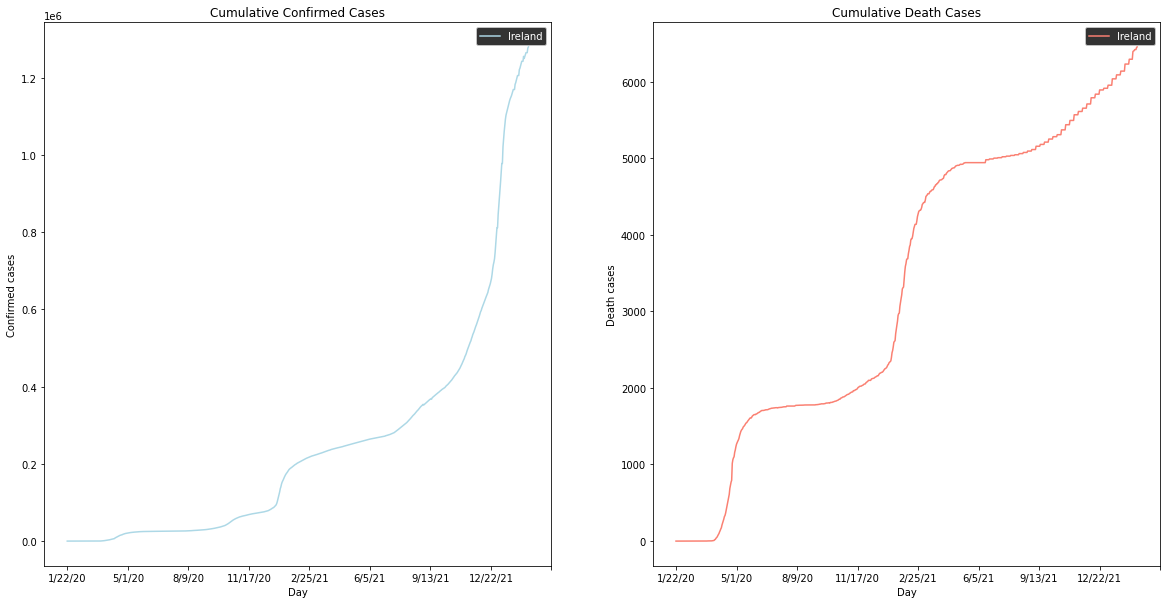

In [83]:
# Ploting subplots of Cumulative Confirmed and Death Cases in Ireland
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.style.use ('dark_background')
hopkings_confirmed['Ireland'].plot(ax=axes[0], color = "lightblue", figsize = (20,10))
# Add Label & Title   
axes[0].set ( title = "Cumulative Confirmed Cases", 
         xlabel = 'Day',
         ylabel = 'Confirmed cases')
#Make the legend Visible
axes[0].legend().set_visible (True)

hopkings_deaths['Ireland'].plot(ax=axes[1], color = "salmon")
# Add Label & Title   
axes[1].set ( title = "Cumulative Death Cases", 
         xlabel = 'Day',
         ylabel = 'Death cases')
#Make the legend Visible
axes[1].legend().set_visible (True)

## Relating Confirmed Cases with Death Toll (Scatter Plot)

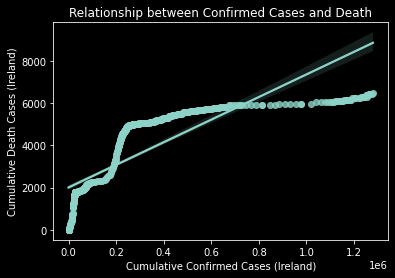

In [84]:
sns.regplot(x =hopkings_confirmed['Ireland'] , y = hopkings_deaths['Ireland'])
plt.xlabel("Cumulative Confirmed Cases (Ireland)")
plt.ylabel("Cumulative Death Cases (Ireland)")
plt.title("Relationship between Confirmed Cases and Death");

In [139]:
# # Ploting subplots of Daily Confirmed and Death Cases in Ireland in Past two months
# fig, axes = plt.subplots(nrows=2, ncols=1)
# plt.style.use ('seaborn-poster')

# # Space between subplots
# plt.subplots_adjust(wspace=0.5, hspace=0.5) # the amount of width and height reserved for blank space between subplots

# daily_confirmed['Ireland'][400:].plot(ax=axes[0], color = "lightblue", figsize = (20,10), kind = 'bar')
# # Add Label & Title   
# axes[0].set ( title = "daily Confirmed Cases", 
#          xlabel = 'Day',
#          ylabel = 'Confirmed cases')
# #Make the legend Visible
# axes[0].legend().set_visible (True)

# daily_deaths['Ireland'][400:].plot(ax=axes[1], color = "salmon", figsize = (20,10), kind = 'bar')
# # Add Label & Title   
# axes[1].set ( title = "daily Death Cases", 
#          xlabel = 'Day',
#          ylabel = 'Death cases')
# #Make the legend Visible
# axes[1].legend().set_visible (True)

In [140]:
# # Ploting subplots of growth of deaths and confirmed numbers in Ireland in Past two months
# fig, axes = plt.subplots(nrows=2, ncols=1)
# plt.style.use ('classic')

# # Space between subplots
# plt.subplots_adjust(wspace=0.5, hspace=0.5) # the amount of width and height reserved for blank space between subplots

# growth_confirmed['Ireland'][400:].plot(ax=axes[0], color = "lightblue", figsize = (20,10), kind = 'bar')
# # Add Label & Title   
# axes[0].set ( title = "Growth Confirmed Cases", 
#          xlabel = 'Day',
#          ylabel = 'Confirmed cases')
# #Make the legend Visible
# axes[0].legend().set_visible (True)

# growth_deaths['Ireland'][400:].plot(ax=axes[1], color = "salmon", figsize = (20,10), kind = 'bar')
# # Add Label & Title   
# axes[1].set ( title = "Growths Death Cases", 
#          xlabel = 'Day',
#          ylabel = 'Death cases')
# #Make the legend Visible
# axes[1].legend().set_visible (True)

In [87]:
Final_data_Johnhopkings = df_confirmed_Ireland .merge(df_deaths_Ireland , how = 'outer', on = None)
Final_data_Johnhopkings.to_csv('Final_data_Johnhopkings.csv')

## Covid-19: Ireland Counties

In [88]:
print ('Current Status of COVID 19 in Ireland:')
print ('Total Number of Confirmed Cases in Ireland till', enddate- timedelta(days=1), covid['Daily_Confirmed'].sum())

Current Status of COVID 19 in Ireland:
Total Number of Confirmed Cases in Ireland till 2022-01-31 1280058.0


In [89]:
covid.describe()

,Population,Lat,Long,Confirmed,Daily_Confirmed,Incident_Rate
count,1.882400e+04,18824.000000,18824.000000,18824.000000,18798.000000,1.879800e+04
mean,1.831487e+05,53.284896,-7.678346,9880.982150,68.095436,3.679673e-09
std,2.528070e+05,0.728441,0.926157,25595.619712,239.306616,7.830926e-09
min,3.204400e+04,51.951700,-9.565000,0.000000,0.000000,0.000000e+00
25%,7.617600e+04,52.640700,-8.534500,670.000000,2.000000,2.015479e-10
50%,1.238505e+05,53.311850,-7.577100,3601.500000,12.000000,9.829735e-10
75%,1.595530e+05,53.916100,-6.836700,9586.250000,46.000000,3.356985e-09
max,1.347359e+06,54.898900,-6.292000,391210.000000,6202.000000,1.136443e-07


In [142]:
# #set up plot
# fig , ax = plt.subplots(figsize = (20,10))
# #plot data
# ax.plot(covid.date, covid.Daily_Confirmed)
# # Customize Plot
# ax.set(title = 'Daily Number of Confirmed Cases in Ireland',
#        xlabel = 'Date',
#        ylabel = 'Daily Positve Cases')
# #styling the plot
# plt.style.use ('tableau-colorblind10')

## Situation in Counties

#### Situatio per day per county

In [141]:
covid_county = covid.drop(columns = ['Confirmed','Incident_Rate' , 'Lat', 'Long'] )
#covid_county.style.background_gradient(cmap = 'Reds')

#### Total Confirmed per County till now

In [92]:
# Grouping by pupulation and  region and then sum the confirmed cases and change to DF
total_cases_county = covid_county.groupby(['region', 'Population'])['Daily_Confirmed'].sum().sort_values(ascending = False).to_frame()
total_cases_county.style.background_gradient(cmap = 'Reds')

,,Daily_Confirmed
region,Population,
Dublin,1347359,391210.000000
Cork,542868,127331.000000
Galway,258058,68074.000000
Kildare,222504,63349.000000
Limerick,194899,53585.000000
Meath,195044,53430.000000
Donegal,159192,48567.000000
Louth,128884,43208.000000
Tipperary,159553,38311.000000


#### Situation in Captial (Dublin)

Dublin is a captial of Ireland with the population of 1,347,359. On 3rd January, this city has expereienced the highest Confirmed cases (3,654)

In [93]:
covid_Dublin = covid[covid['region'] == 'Dublin']
covid_Dublin = covid_Dublin.drop(columns= ['region', 'Confirmed', 'Population','Incident_Rate'] )

In [130]:
#covid_Dublin.style.background_gradient(cmap = 'Reds')

In [95]:
fig = go.Figure()
fig.add_trace (go.Scatter(x = covid_Dublin['date'], y= covid_Dublin['Daily_Confirmed'], mode = 'lines+markers', name = 'Total Positve Cases'))
fig.update_layout(title_text = ' Daily Number of COVID-19 Cases in Dublin', plot_bgcolor = 'rgb(230,230,230)')
fig.show()

In [96]:
covid_county = covid.copy()

In [97]:
covid_county = covid_county.drop (columns = ['Population', 'Lat', 'Long'])

In [98]:
covid_county = covid_county.groupby(covid_county.region).sum()
covid_county = covid_county.drop (columns= ['Confirmed', 'Incident_Rate'])
covid_county = covid_county.sort_values(by = 'Daily_Confirmed', ascending= False)

In [129]:
import plotly.express as px
# Plots Styles
plt.rcdefaults() 
sns.set_style("whitegrid")
sns.set_style('ticks')
fig = px.bar(covid_county, x=covid_county.index, y='Daily_Confirmed', labels={'x':'County'},
             color="Daily_Confirmed", color_continuous_scale=px.colors.sequential.Brwnyl)
plt.rcdefaults() 
sns.set_style("whitegrid")
sns.set_style('ticks')
fig.update_layout(title_text='Confirmed COVID-19 cases by counties')
fig.update_layout(paper_bgcolor="white")
fig.show()


## Google


In [101]:
ireland_google = google[google['County'].isnull()].reset_index()
ireland_google = ireland_google.drop(columns = ['country region',
                                      'County',
                                      'index'])

As we see, Residential has the highest increase with an average of 15.24%. Then we are seeing Parks with 12.60% increase. Transit Satation has witnees the highst decrease -50% and then Retail and Recreation with -42.92% in average.

In [103]:
ireland_google.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Retail and Recreation,696.0,-29.501437,24.442209,-94.0,-48.0,-25.0,-8.00,36.0
Grocery and Pharmacy,696.0,4.251437,15.508596,-92.0,-3.0,4.0,16.00,65.0
Parks,696.0,29.558908,44.644521,-69.0,-1.0,23.0,56.00,193.0
Transit Stations,696.0,-43.969828,15.468063,-86.0,-56.0,-41.0,-32.00,-3.0
Workplaces,696.0,-33.711207,19.248431,-86.0,-45.0,-34.0,-24.75,13.0
Residential,696.0,11.520115,7.790948,-3.0,6.0,10.0,16.00,35.0


In [104]:
Ireland_mobility_columns = [ireland_google['Retail and Recreation'], ireland_google['Grocery and Pharmacy'], ireland_google['Parks'], ireland_google['Transit Stations'], ireland_google['Workplaces'], ireland_google['Residential']]
fig = go.Figure()
fig.add_trace (go.Scatter(x = ireland_google['Date'], y= Ireland_mobility_columns[0], mode = 'lines+markers', name = 'Total Positve Cases'))
fig.update_layout(title_text = ' Retail and Recreation mobility changes in Ireland', plot_bgcolor = 'rgb(230,230,230)')
fig.show()

In the below correlation matrix. Correlation is a statistic that measures the degree to which two variables move in relation to each other. The interesting point is that we see belows:

    - A negative correlation occurs between two factors or variables when they consistently move in opposite directions to one anothe:
        -  Residential & WorkPlace : -0.9
        -  Residential & Transit Stations : -0.8
        - Residential & Retail and Recreation : -0.7       
        
    - A Positive Correlations:
        - Workplace & Transit Stations : 0.6
        - Transit Stattion & Retail and Recreation : 0.8
        - Parks & Retail and recration : 0.6
        - Groceey and Pharmacy : 0.7
 

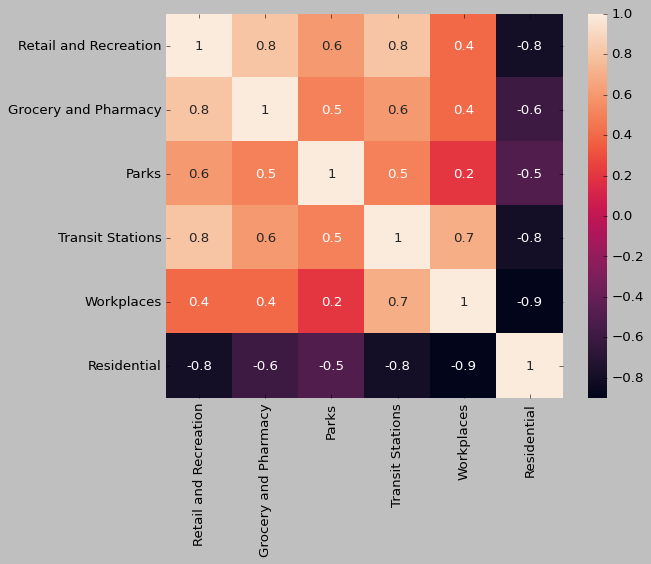

In [110]:
correlation_matrix_Irelan_mobility = ireland_google.corr().round(1)
sns.heatmap(data=correlation_matrix_Irelan_mobility, annot=True);

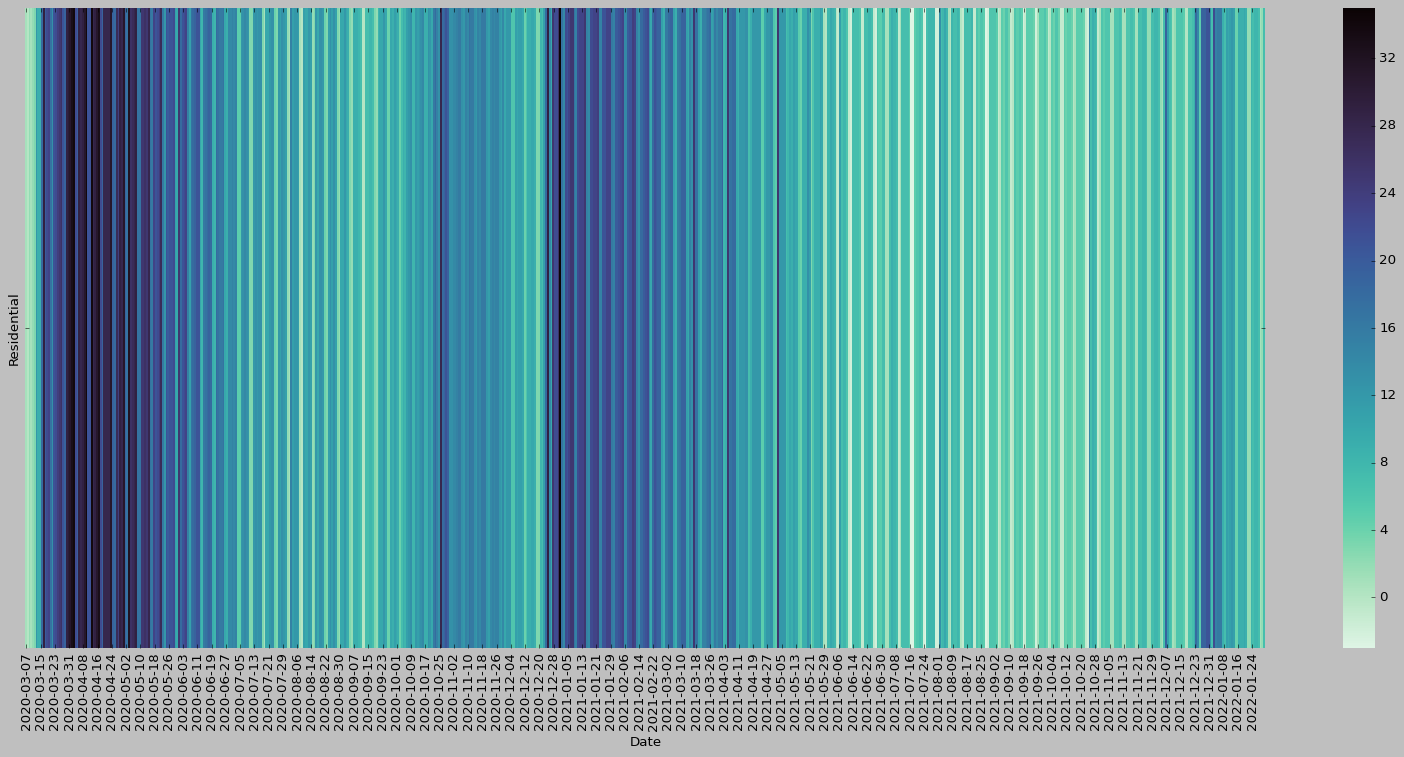

In [116]:
heatmap_IE_mob6 = pd.pivot_table(ireland_google, values='Residential', columns='Date')
fig, ax = plt.subplots(figsize=(25,10)) 
plot_Ireland_mobility=sns.heatmap(heatmap_IE_mob6, cmap="mako_r")
